<a href="https://colab.research.google.com/github/cdwangco/SentimentAnalysisProject/blob/main/MLProjectYTSentimentAnalysis2ndDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import warnings
warnings.filterwarnings('ignore')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats.stats import RanksumsResult
# Evaluate the test using Flair baseline
from flair.models import TextClassifier
from flair.data import Sentence
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, accuracy_score
import transformers as ppb
import matplotlib.pyplot as plt


/Users/josegarza/opt/anaconda3/envs/ai/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-02 13:21:43.615860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data/comments.csv')

In [3]:
print(df.head())
df = df[:2000]
print(df['Sentiment'].value_counts()) #we have a balanced data set

   Unnamed: 0     Video ID                                            Comment  \
0           0  wAZZ-UWGVHI  Let's not forget that Apple Pay in 2014 requir...   
1           1  wAZZ-UWGVHI  Here in NZ 50% of retailers don’t even have co...   
2           2  wAZZ-UWGVHI  I will forever acknowledge this channel with t...   
3           3  wAZZ-UWGVHI  Whenever I go to a place that doesn’t take App...   
4           4  wAZZ-UWGVHI  Apple Pay is so convenient, secure, and easy t...   

   Likes  Sentiment  
0   95.0        1.0  
1   19.0        0.0  
2  161.0        2.0  
3    8.0        0.0  
4   34.0        2.0  
2.0    1096
1.0     556
0.0     348
Name: Sentiment, dtype: int64


In [4]:
df = df.iloc[:,[2,4]]

In [5]:
df['1'] = df['Sentiment'].apply(lambda x: 0 if x <= 1 else 1)
df = df.iloc[:,[0,2]]

In [6]:
df = df.rename(columns={'Comment': 0})

In [7]:
analyzer = SentimentIntensityAnalyzer()

def getVader(text):
  score = analyzer.polarity_scores(text)
  return 1 if score['compound'] >= 0 else 0


In [8]:
df['Vader'] = df[0].apply(getVader)
df.head()

,0,1,Vader
0,Let's not forget that Apple Pay in 2014 requir...,0,1
1,Here in NZ 50% of retailers don’t even have co...,0,1
2,I will forever acknowledge this channel with t...,1,1
3,Whenever I go to a place that doesn’t take App...,0,0
4,"Apple Pay is so convenient, secure, and easy t...",1,1


In [9]:
classifier = TextClassifier.load('en-sentiment')

2022-12-02 13:21:53,743 loading file /Users/josegarza/.flair/models/sentiment-en-mix-distillbert_4.pt


In [10]:
def predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value']
    return 0 if value == 'NEGATIVE' else 1

def flairPredict(sentence):
  result = predict(sentence)
  return result

In [11]:

df['FlairScore'] = df[0].apply(flairPredict)
df.head()
print(len(df))

2000


In [12]:
def getSubj(text):
  return TextBlob(text).sentiment.subjectivity

def getPol(text):
  return TextBlob(text).sentiment.polarity

def binarize(float):
  return 1 if float > 0 else 0

In [13]:

data = df.rename(columns={0: 'Comment', '1':'Label'})
data['Polarity'] = data['Comment'].apply(getPol)
data['TextBlob'] = data['Polarity'].apply(binarize)
data.head()

,Comment,Label,Vader,FlairScore,Polarity,TextBlob
0,Let's not forget that Apple Pay in 2014 requir...,0,1,0,0.075606,1
1,Here in NZ 50% of retailers don’t even have co...,0,1,0,0.160000,1
2,I will forever acknowledge this channel with t...,1,1,1,0.000000,0
3,Whenever I go to a place that doesn’t take App...,0,0,0,-0.183333,0
4,"Apple Pay is so convenient, secure, and easy t...",1,1,1,0.208333,1


In [14]:
# Do BERT in parallel to compare baseline performance
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [15]:
data['Comment'] = [d[:1024] for d in data['Comment']]

In [16]:
tokenized = data['Comment'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized.head())

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
print(f'max length: {max_len}')
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print(np.array(padded).shape)

attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

0    [101, 2292, 1005, 1055, 2025, 5293, 2008, 6207...
1    [101, 2182, 1999, 20008, 2753, 1003, 1997, 166...
2    [101, 1045, 2097, 5091, 13399, 2023, 3149, 200...
3    [101, 7188, 1045, 2175, 2000, 1037, 2173, 2008...
4    [101, 6207, 3477, 2003, 2061, 14057, 1010, 585...
Name: Comment, dtype: object
max length: 330
(2000, 330)
(2000, 330)


In [17]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)
print(input_ids.shape, 'and attention mask', attention_mask.shape)

torch.Size([2000, 330]) and attention mask torch.Size([2000, 330])


In [18]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
    print(last_hidden_states)
features = last_hidden_states[0][:,0,:].numpy()

BaseModelOutput(last_hidden_state=tensor([[[-2.1693e-01, -1.2050e-02,  1.8420e-01,  ..., -9.6947e-02,
           2.2397e-01,  2.8831e-01],
         [ 6.0008e-01,  8.7192e-03, -3.5998e-01,  ...,  5.9583e-01,
           9.1790e-01,  7.4841e-02],
         [ 6.4942e-01,  2.7043e-01,  1.7726e-01,  ...,  2.7444e-02,
          -6.5146e-01, -5.4791e-01],
         ...,
         [ 2.7058e-01,  1.4919e-01,  2.4826e-01,  ..., -8.0993e-02,
          -1.1414e-01,  1.0607e-01],
         [ 3.2488e-01,  1.0074e-01,  2.0944e-01,  ...,  2.2527e-02,
          -2.5998e-01, -5.5139e-02],
         [ 3.9866e-01,  1.7699e-01,  2.2658e-01,  ..., -3.2192e-02,
          -2.4821e-01, -7.7290e-02]],

        [[ 1.8788e-01,  9.6403e-02,  1.1071e-01,  ..., -1.5396e-01,
           2.7091e-01,  2.5518e-01],
         [ 9.8387e-02, -4.5446e-03,  3.3212e-03,  ..., -5.1635e-01,
           5.8905e-01, -1.9741e-01],
         [-5.2779e-01, -2.9226e-01, -1.1803e-02,  ..., -6.0419e-01,
           4.8230e-01, -1.3399e-02],
     

In [19]:
lr_clf = LogisticRegression()
clf = lr_clf.fit(features,data['Label'])
data['Bert'] = clf.predict(features)
data.head()
print(lr_clf.score(features, data['Label']))

0.9225


In [20]:
print('TextBlob Confusion Matrix')
print(confusion_matrix(data['Label'],data['TextBlob']))
textBlobAcc = accuracy_score(data['Label'],data['TextBlob'])
print('accuracy = ', textBlobAcc)

print('Vader Confusion Matrix')
print(confusion_matrix(data['Label'],data['Vader']))
vaderAcc = accuracy_score(data['Label'],data['Vader'])
print('accuracy = ',vaderAcc)

print('BERT Confusion Matrix')
print(confusion_matrix(data['Label'],data['Bert']))
bertAcc = accuracy_score(data['Label'],data['Bert'])
print('accuracy = ',bertAcc)

print('Flair Confusion Matrix')
print(confusion_matrix(data['Label'],data['FlairScore']))
flairAcc = accuracy_score(data['Label'],data['FlairScore'])
print('accuracy = ',flairAcc)

names = ['TextBlob','Vader', 'BERT', 'Flair']
accuracies = [textBlobAcc,vaderAcc, bertAcc, flairAcc]

TextBlob Confusion Matrix
[[569 335]
 [201 895]]
accuracy =  0.732
Vader Confusion Matrix
[[ 302  602]
 [  62 1034]]
accuracy =  0.668
BERT Confusion Matrix
[[ 833   71]
 [  84 1012]]
accuracy =  0.9225
Flair Confusion Matrix
[[518 386]
 [102 994]]
accuracy =  0.756


[0.732, 0.668, 0.9225, 0.756]


<BarContainer object of 4 artists>

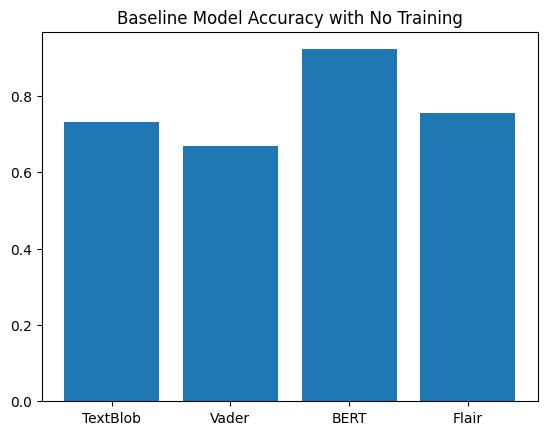

In [21]:
plt.title('Baseline Model Accuracy with No Training')
print(accuracies)
plt.bar(names,accuracies)

In [22]:
score_to_text = {0:'BAD', 1:'GOOD'}

In [23]:
sentence = "I love the way you explained, plus the diversity :)"
max_len = 30
sentence_pred = flairPredict(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

sentence = "I hate the way you explained, plus no diversity"
sentence_pred = flairPredict(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

GOOD: I love the way you explained, ...
BAD: I hate the way you explained, ...
